# 读入

In [229]:
import numpy as np
import math

# 单位一致性
ikind = np.int32
rkind = np.float64

# 绘图精度、比例
DIVIDE = 101
UNIT_M = 100
UNIT_FQ = 100
UNIT_FN = 50

# 文件名序号（批处理相关）
NameIndex = 5

### 结构体类定义
- 结点`Joint`
- 单元杆件`Element`
- 结点荷载`JointLoad`
- 单元荷载`ElemLoad`

In [230]:
# 结点
class Joint:
    def __init__(self, X, Y, GDOF):
        self.X = X
        self.Y = Y
        self.GDOF = GDOF    # 结点自由度编码

# 单元杆件
class Element:
    def __init__(self, Joint1, Joint2, EA, EI, mass=0):
        self.Joint1 = Joint1
        self.Joint2 = Joint2
        self.GlbDOF = self.compute_GlbDOF()     # 单元自由度编码
        self.Len, self.cosA, self.sinA = self.compute_properties()
        self.EA = EA
        self.EI = EI
        self.mass = mass
        self.ET = self.compute_TransMatrix()  # 变换矩阵
        self.EKR = self.compute_StiffnessMatrix() # 刚度矩阵（局部坐标）
        self.EK = np.dot(np.dot(self.ET.T, self.EKR), self.ET) # 刚度矩阵（全局坐标）
        self.EForceR = np.zeros(6, dtype=rkind) # 单元结点约束力（局部坐标）
        self.EP = np.zeros(6, dtype=rkind) # 等效结点荷载（全局坐标）
        self.Disp = np.zeros(6, dtype=rkind) # 结点位移（全局坐标）
        self.ReactionR = np.zeros(6, dtype=rkind) # 杆端力（局部坐标）
        self.FN = np.zeros(DIVIDE, dtype=rkind) 
        self.FQ = np.zeros(DIVIDE, dtype=rkind)
        self.M = np.zeros(DIVIDE, dtype=rkind)

    def compute_GlbDOF(self):
        GlbDOF = np.zeros(6, dtype=ikind)
        GlbDOF[0:3] = self.Joint1.GDOF[0:3]
        GlbDOF[3:6] = self.Joint2.GDOF[0:3]
        return GlbDOF

    def compute_properties(self):
        dx = self.Joint2.X - self.Joint1.X
        dy = self.Joint2.Y - self.Joint1.Y
        Len = np.sqrt(dx**2 + dy**2)
        cosA = dx / Len
        sinA = dy / Len
        return Len, cosA, sinA
    
    def compute_TransMatrix(self):
        ET = np.zeros((6, 6), dtype=rkind)
        ET[0, 0:2] = [self.cosA, self.sinA]
        ET[1, 0:2] = [-self.sinA, self.cosA]
        ET[2, 2] = 1
        ET[3, 3:5] = [self.cosA, self.sinA]
        ET[4, 3:5] = [-self.sinA, self.cosA]
        ET[5, 5] = 1
        return ET
    
    def compute_StiffnessMatrix(self):
        L = self.Len
        EA = self.EA
        EI = self.EI
        k = np.zeros((6, 6), dtype=rkind)
        k[0, 0] = EA / L
        k[0, 3] = -EA / L
        k[1, 1] = 12 * EI / L**3
        k[1, 2] = 6 * EI / L**2
        k[1, 4] = -12 * EI / L**3
        k[1, 5] = 6 * EI / L**2
        k[2, 1] = 6 * EI / L**2
        k[2, 2] = 4 * EI / L
        k[2, 4] = -6 * EI / L**2
        k[2, 5] = 2 * EI / L
        k[3, 0] = -EA / L
        k[3, 3] = EA / L
        k[4, 1] = -12 * EI / L**3
        k[4, 2] = -6 * EI / L**2
        k[4, 4] = 12 * EI / L**3
        k[4, 5] = -6 * EI / L**2
        k[5, 1] = 6 * EI / L**2
        k[5, 2] = 2 * EI / L
        k[5, 4] = -6 * EI / L**2
        k[5, 5] = 4 * EI / L
        return k

# 结点荷载
class JointLoad:
    def __init__(self, Joint, LodDOF, LodVal):
        self.Joint = Joint
        self.LodDOF = LodDOF
        self.LodVal = LodVal

# 单元荷载
class ElemLoad:
    def __init__(self, Element, Index, Pos, LodVal):
        self.Element = Element
        self.Index = Index
        self.Pos = Pos
        self.LodVal = LodVal

### 数据输入与初始化类
- 静力分析(共一行）：           1
- 控制参数（共一行）：          NElem,NJoint,NGlbDOF,NJLoad,NELoad
- 结点数据（共 Njoint行)：      x, y, GDOF(1:3)
- 单元数据（共 Nelem 行）：     JointNo(1:2) , EA, EI
- 结点荷载数据（共 NJLoad行)：  JointNo, LodDOF, Lodval
- 单元荷载数据（共 NELoad 行)： ElemNo, Index, Pos, Lodval

In [231]:
with open('InputData'+str(NameIndex)+'.txt', 'r') as file:
        op = file.readline().strip()
        
        NElem, NJoint, NGlbDOF, NJLoad, NELoad = map(int, file.readline().split(','))

        # Read Joint data
        Joints = []
        for _ in range(NJoint):
            X, Y, GDOF1, GDOF2, GDOF3 = map(float, file.readline().split(','))
            GDOF = np.array([GDOF1, GDOF2, GDOF3], dtype=np.int32)
            joint = Joint(X, Y, GDOF)
            Joints.append(joint)

        # Read Element data
        Elems = []
        for _ in range(NElem):
            JointNo1, JointNo2, EA, EI = map(float, file.readline().split(','))
            Joint1 = Joints[int(JointNo1) - 1]
            Joint2 = Joints[int(JointNo2) - 1]
            element = Element(Joint1, Joint2, EA, EI)
            Elems.append(element)
        
        # Read Joint Load data
        JointLoads = []
        for _ in range(NJLoad):
            JointNo, LodDOF, LodVal = map(float, file.readline().split(','))
            Joint = Joints[int(JointNo) - 1]
            jointLoad = JointLoad(Joint, LodDOF, LodVal)
            JointLoads.append(jointLoad)
        
        # Read Element Load data
        ElemLoads = []
        for _ in range(NELoad):
            ElemNo, Index, Pos, LodVal = map(float, file.readline().split(','))
            Element = Elems[int(ElemNo) - 1]
            elemLoad = ElemLoad(Element, Index, Pos, LodVal)
            ElemLoads.append(elemLoad)



`*非必需运行`
杆件长度、局部坐标、定位向量、刚度矩阵等

In [232]:
for i, element in enumerate(Elems):
    print("Element", i+1, "Length:", element.Len)
    print("Element", i+1, "cosA:", element.cosA)
    print("Element", i+1, "sinA:", element.sinA)
    print("Element", i+1, "GlbDOF:", element.GlbDOF)
    # print("Element", i+1, "ET:\n", element.ET)
    print("Element", i+1, "EK:\n", element.EK)
    print("\n")

Element 1 Length: 2.5
Element 1 cosA: 0.0
Element 1 sinA: 1.0
Element 1 GlbDOF: [0 0 0 1 2 3]
Element 1 EK:
 [[ 2.304000000e+09  0.000000000e+00 -2.880000000e+09 -2.304000000e+09
   0.000000000e+00 -2.880000000e+09]
 [ 0.000000000e+00  2.000000000e+07  0.000000000e+00  0.000000000e+00
  -2.000000000e+07  0.000000000e+00]
 [-2.880000000e+09  0.000000000e+00  4.800000000e+09  2.880000000e+09
   0.000000000e+00  2.400000000e+09]
 [-2.304000000e+09  0.000000000e+00  2.880000000e+09  2.304000000e+09
   0.000000000e+00  2.880000000e+09]
 [ 0.000000000e+00 -2.000000000e+07  0.000000000e+00  0.000000000e+00
   2.000000000e+07  0.000000000e+00]
 [-2.880000000e+09  0.000000000e+00  2.400000000e+09  2.880000000e+09
   0.000000000e+00  4.800000000e+09]]


Element 2 Length: 2.5
Element 2 cosA: 0.0
Element 2 sinA: 1.0
Element 2 GlbDOF: [0 0 0 4 5 6]
Element 2 EK:
 [[ 2.304000000e+09  0.000000000e+00 -2.880000000e+09 -2.304000000e+09
   0.000000000e+00 -2.880000000e+09]
 [ 0.000000000e+00  2.00000000

# 计算

### 整体刚度矩阵$\mathbf{K}$

In [233]:
# 整体刚度矩阵
KG = np.zeros((NGlbDOF, NGlbDOF), dtype=rkind)
for element in Elems:
    for i in range(6):
        if (element.GlbDOF[i]):
            for j in range(6):
                if (element.GlbDOF[j]):
                    # print(f"({element.GlbDOF[i]},{element.GlbDOF[j]}): {element.EK[i, j]}")
                    KG[element.GlbDOF[i]-1, element.GlbDOF[j]-1] += element.EK[i, j]
print(KG)

[[ 2.539567597e+09 -4.630099747e+08  2.946783897e+09 ...  0.000000000e+00
   0.000000000e+00  0.000000000e+00]
 [-4.630099747e+08  9.346082559e+09  4.066432206e+09 ...  0.000000000e+00
   0.000000000e+00  0.000000000e+00]
 [ 2.946783897e+09  4.066432206e+09  7.933919485e+09 ...  0.000000000e+00
   0.000000000e+00  0.000000000e+00]
 ...
 [ 0.000000000e+00  0.000000000e+00  0.000000000e+00 ...  1.628541228e+08
   3.256366913e+08 -1.526489073e+08]
 [ 0.000000000e+00  0.000000000e+00  0.000000000e+00 ...  3.256366913e+08
   6.513091597e+08 -3.052978145e+08]
 [ 0.000000000e+00  0.000000000e+00  0.000000000e+00 ... -1.526489073e+08
  -3.052978145e+08  1.908111341e+08]]


### 单元等效结点载荷$P_E^{(i)}$

In [234]:
def FixedEndForces(ElemLoad):
    element = ElemLoad.Element
    Index = ElemLoad.Index
    Pos = ElemLoad.Pos
    LodVal = ElemLoad.LodVal
    L = element.Len
    EA = element.EA
    EI = element.EI
    EForceR = np.zeros(6, dtype=rkind)
    if (Index == 1):    # 分布力
        EForceR[1] = -(LodVal * Pos / 2) * (2 - 2*(Pos/L)**2 + (Pos/L)**3)
        EForceR[2] = -(LodVal * (Pos ** 2) / 12) * (6 - 8 * Pos/L + 3 * (Pos/L)**2)
        EForceR[4] = -(LodVal * (Pos ** 3) / (2*(L**2))) * (2 - Pos/L)
        EForceR[5] = (LodVal * (Pos ** 3) / (12*L)) * (4 - 3 * Pos/L)
    elif (Index == 2):  # 集中力
        EForceR[1] = LodVal * (1 - Pos/L)**2 * (1 + 2 * Pos/L)
        EForceR[2] = LodVal * Pos * (Pos/L - 1)**2
        EForceR[4] = LodVal * (Pos/L)**2 * (1 + 2 * (1 - Pos/L))
        EForceR[5] = LodVal * Pos**2 * (Pos/L - 1)
    elif (Index == 3):  # 集中力矩
        EForceR[1] = LodVal * 6 * Pos * (L - Pos) / L**3
        EForceR[2] = LodVal * (1 - Pos/L) * (2 - 3 * (1-Pos/L))
        EForceR[4] = - LodVal * 6 * Pos * (L - Pos) / L**3
        EForceR[5] = LodVal * (Pos/L) * (2 - 3 * (Pos/L))
        
    return EForceR

for ElemLoad in ElemLoads:   # 重复运行会累加！！！前面可以加个归零逻辑
    element = ElemLoad.Element
    EForceR = FixedEndForces(ElemLoad)
    element.EForceR += EForceR
    element.EP -= np.dot(element.ET.T, EForceR)
    print(element.EForceR)


[ 0.000000000  8.746427842  2.550000000  0.000000000  8.743572158
 -2.549999592]
[ 0.000000000 -8.746427842 -2.550000000  0.000000000 -8.743572158
  2.549999592]
[ 0.000000000  5.830951895  1.133333333  0.000000000  5.829048105
 -1.133333152]
[ 0.000000000 -5.830951895 -1.133333333  0.000000000 -5.829048105
  1.133333152]
[ 0.000000000  5.590169944  1.041666667  0.000000000  5.589830056
 -1.041666661]
[ 0.000000000 -5.590169944 -1.041666667  0.000000000 -5.589830056
  1.041666661]
[ 0.000000000  4.192627459  0.585937500  0.000000000  4.197372541
 -0.585936373]
[ 0.000000000 -4.192627459 -0.585937500  0.000000000 -4.197372541
  0.585936373]


### 整体总结点荷载向量$P$

In [235]:
# 整体结点荷载向量
PG = np.zeros(NGlbDOF, dtype=rkind)
for Elem in Elems:
    for i in range(6):
        if (Elem.GlbDOF[i]):
            PG[Elem.GlbDOF[i]-1] += Elem.EP[i]

for JointLoad in JointLoads:
    Joint = JointLoad.Joint
    LodDOF = int(JointLoad.LodDOF)
    LodVal = JointLoad.LodVal
    GDOFNo = Joint.GDOF[LodDOF-1]-1
    PG[GDOFNo] += LodVal
print(PG)

[  4.377122066  -8.754244131  -0.455730293   0.000000000   0.000000000
   0.000000000   0.000000000   0.000000000   0.000000000  -4.377122066
  -8.754244131   0.455730293   5.499847998  -9.999695995  -0.091666672
  -5.499847998  -9.999695995   0.091666672   0.000000000 -15.000000000
   0.000000000   7.499020508 -12.498367514  -1.416666848   0.000000000
 -15.000000000   0.000000000  -7.499020508 -12.498367514   1.416666848
   0.000000000 -25.000000000   0.000000000   0.000000000 -24.995102542
   0.000000000   1.875000001  -3.750000001  -0.585937500  -1.875000001
  -3.750000001   0.585937500]


### 求解位移向量$\Delta$

In [236]:
# 整体位移向量
DG = np.linalg.solve(KG, PG)
print(DG)

[ 0.000000065 -0.000001856 -0.000000042  0.000000051 -0.000001894
 -0.000000040 -0.000000051 -0.000001894  0.000000040 -0.000000065
 -0.000001856  0.000000042  0.000000074 -0.000002072 -0.000000050
 -0.000000074 -0.000002072  0.000000050 -0.000000723 -0.000002121
 -0.000000046 -0.000000689 -0.000002775 -0.000000070  0.000000723
 -0.000002121  0.000000046  0.000000689 -0.000002775  0.000000070
 -0.000000000 -0.000002833 -0.000000000 -0.000000000 -0.000002624
  0.000000000  0.000000056 -0.000001838 -0.000000017 -0.000000056
 -0.000001838  0.000000017]


In [237]:
np.allclose(np.dot(KG, DG), PG)

True

### 求单元杆端力$\bar{F^e}$

In [238]:
# 单元杆端力
for Elem in Elems:
    for i in range(6):
        if (Elem.GlbDOF[i]):
            Elem.Disp[i] = DG[Elem.GlbDOF[i]-1]
    Elem.ReactionR = np.dot(Elem.EKR,np.dot(Elem.ET, Elem.Disp)) + Elem.EForceR
    print(Elem.ReactionR)
    print("\n")

[ 37.113986598  28.577940695  85.951313219 -37.113986598 -28.577940695
 -14.506461481]


[ 37.885872315   1.983120254  50.635392487 -37.885872315  -1.983120254
 -45.677591853]


[ 37.885872315  -1.983120254 -50.635392487 -37.885872315   1.983120254
  45.677591853]


[ 37.113986598 -28.577940695 -85.951313219 -37.113986598  28.577940695
  14.506461481]


[ 17.729045160   1.942600358  59.362757458 -17.729045160  -1.942600358
 -58.391457279]


[ 17.729045160  -1.942600358 -59.362757458 -17.729045160   1.942600358
  58.391457279]


[  0.763038182  -5.113676687  10.549244597  -0.763038182   5.113676687
 -13.617450609]


[  0.763038182   5.113676687 -10.549244597  -0.763038182  -5.113676687
  13.617450609]


[-0.162058537 -0.000000000 -0.000000000  0.162058537  0.000000000
  0.000000000]


[  0.054806543 -20.156827155 -11.287310766  -0.054806543  20.156827155
  -8.869516389]


[  0.054806543  20.156827155   8.869516389  -0.054806543 -20.156827155
  11.287310766]


[  3.185884260  15.76303818

# 输出结果

### 输出至文件
- 结构体信息（共一行）： 10 0
- 杆端位移（用整体坐标，共NElem行）：$u_1,\ v_1,\ \theta_1,\ u_2,\ v_2,\ \theta_2$ 
- 杆端内力（用局部坐标，共NElem行）：$F_{n1}, F_{\tau 1}, M_1, F_{n2}, F_{\tau 2}, M_2$

In [239]:
np.set_printoptions(precision=9, floatmode='fixed', suppress=True)

# 打开文件并覆写数据
with open('OutputData'+str(NameIndex)+'.txt', 'w') as file:
    file.write('# 位移计算：\n')
    file.write('\t单位：位移(默认),转角(默认)\n')
    file.write('  ' + '_'*100 + '\n')
    file.write('\t{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}\n'.format('ElemNo', 'End1 u', 'End1 v', 'End1 θ', 'End2 u', 'End2 v', 'End2 θ'))
    file.write('  ' + '-'*100 + '\n')
    for i in range(NElem):
        disp = ['{:<15.9f}'.format(d) for d in Elems[i].Disp]
        file.write('\t{:<10}'.format(str(i+1)) + ''.join(disp) + '\n')
    file.write('  ' + '_'*100 + '\n')
    file.write('\t正负号规定满足：u沿x轴为正，v沿y轴为正，θ逆时针旋转为正。\n\n')

    file.write('\n\n')
    file.write('# 内力计算：\n')
    file.write('\t单位：力(默认),力矩(默认)\n')
    file.write('  ' + '_'*100 + '\n')
    file.write('\t{:<10}{:<15}{:<15}{:<15}{:<15}{:<15}{:<15}\n'.format('ElemNo', 'End1 FN', 'End1 FQ', 'End1 M', 'End2 FN', 'End2 FQ', 'End2 M'))
    file.write('  ' + '-'*100 + '\n')
    for i in range(NElem):
        reaction = ['{:<15.9f}'.format(r) for r in Elems[i].ReactionR]
        file.write('\t{:<10}'.format(str(i+1)) + ''.join(reaction) + '\n')
    file.write('  ' + '_'*100 + '\n')
    file.write('\t正负号规定满足：FN沿x轴为正，FQ沿y轴为正，M逆时针旋转为正。\n\n')

### 绘图

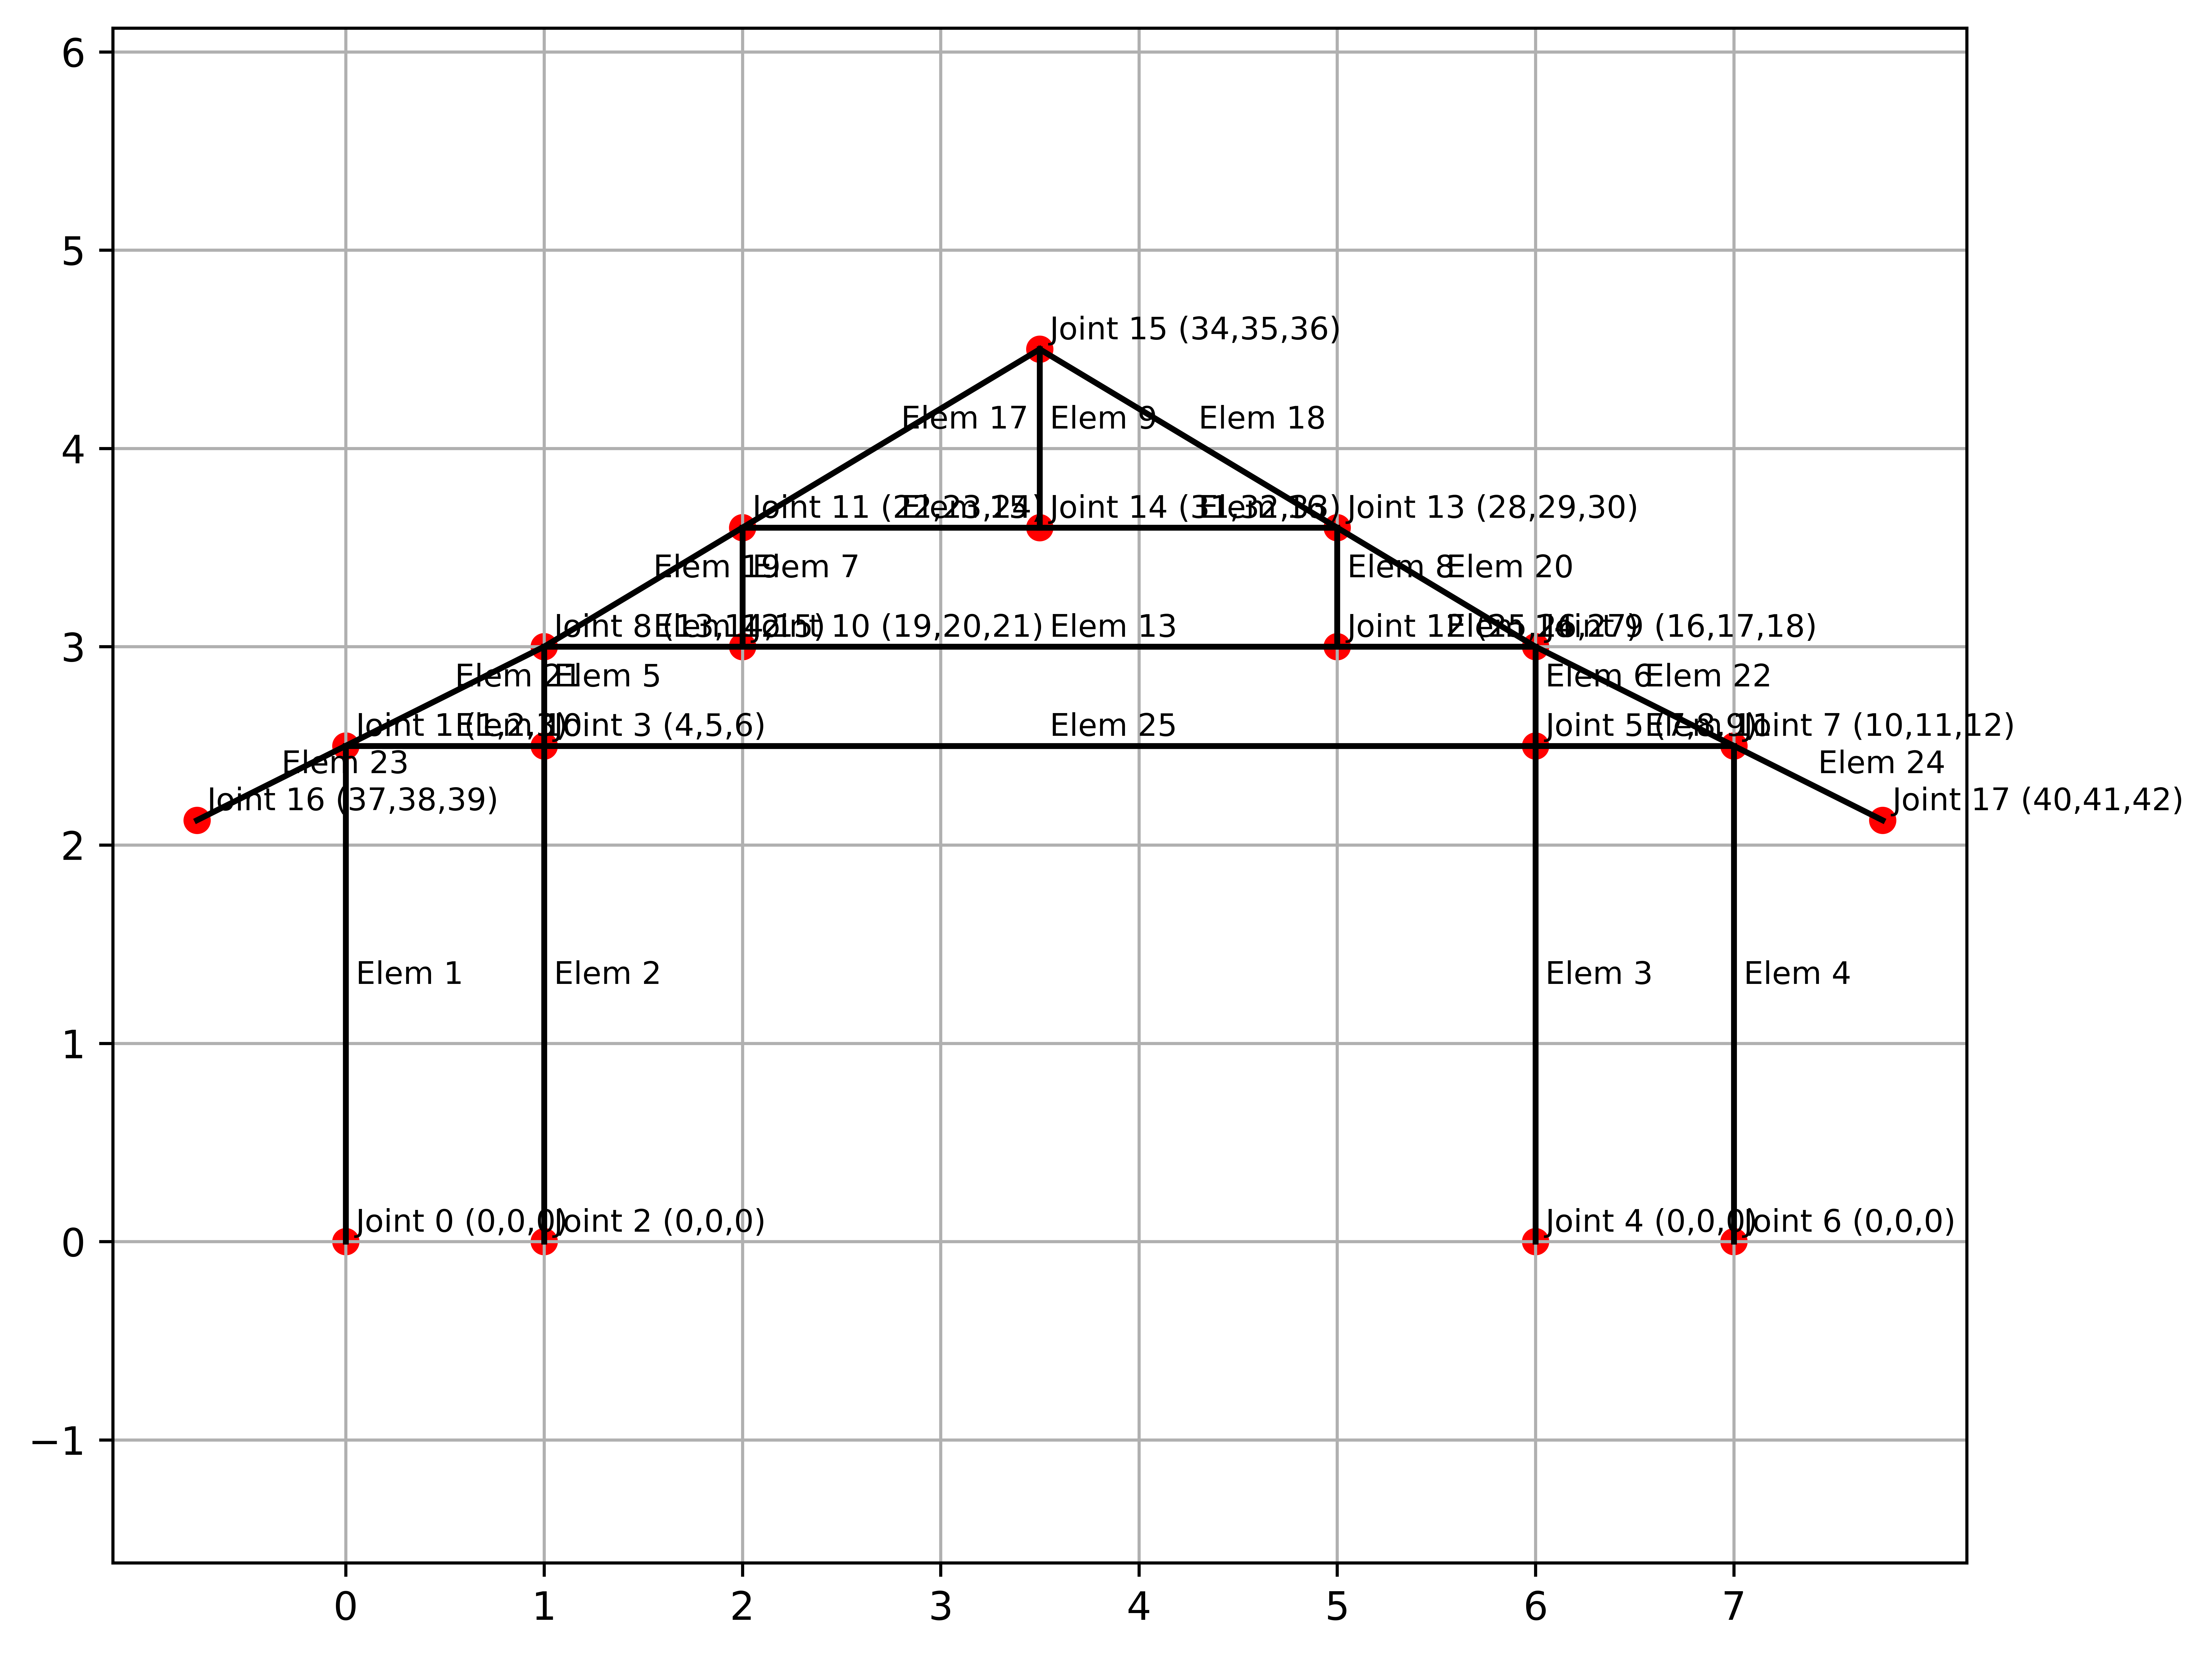

In [240]:
import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
# matplotlib.rcParams['font.family'] = 'Times New Roman'

# 创建一个新的图形
plt.figure(figsize=(8, 6), dpi=500)
x_coords = []
# 遍历元素列表
for i, elem in enumerate(Elems):
    # 获取元素的两个端点的坐标
    x1, y1 = elem.Joint1.X, elem.Joint1.Y
    x2, y2 = elem.Joint2.X, elem.Joint2.Y
    x_coords.extend([x1, x2])

    # 绘制一条从第一个端点到第二个端点的线
    plt.plot([x1, x2], [y1, y2], 'k-')

    # 计算元素的中点坐标
    mx, my = (x1 + x2) / 2, (y1 + y2) / 2

    # 在中点位置添加元素标签
    plt.text(mx+0.05, my+0.05, f'Elem {i+1}', fontsize=8, ha='left')

# 遍历节点列表
for j, joint in enumerate(Joints):
    GDOF = joint.GDOF
    # 获取节点的坐标
    x, y = joint.X, joint.Y
    # 绘制节点
    plt.scatter(x, y, color='r')

    # 在节点位置添加节点标签
    plt.text(x+0.05, y+0.05, f'Joint {j} ({GDOF[0]},{GDOF[1]},{GDOF[2]})', fontsize=8, ha='left')

plt.xticks(range(int(min(x_coords)), int(max(x_coords)) + 1))
plt.ylim(0,6.5)
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.savefig('Structure'+str(NameIndex)+'.png')
plt.show()

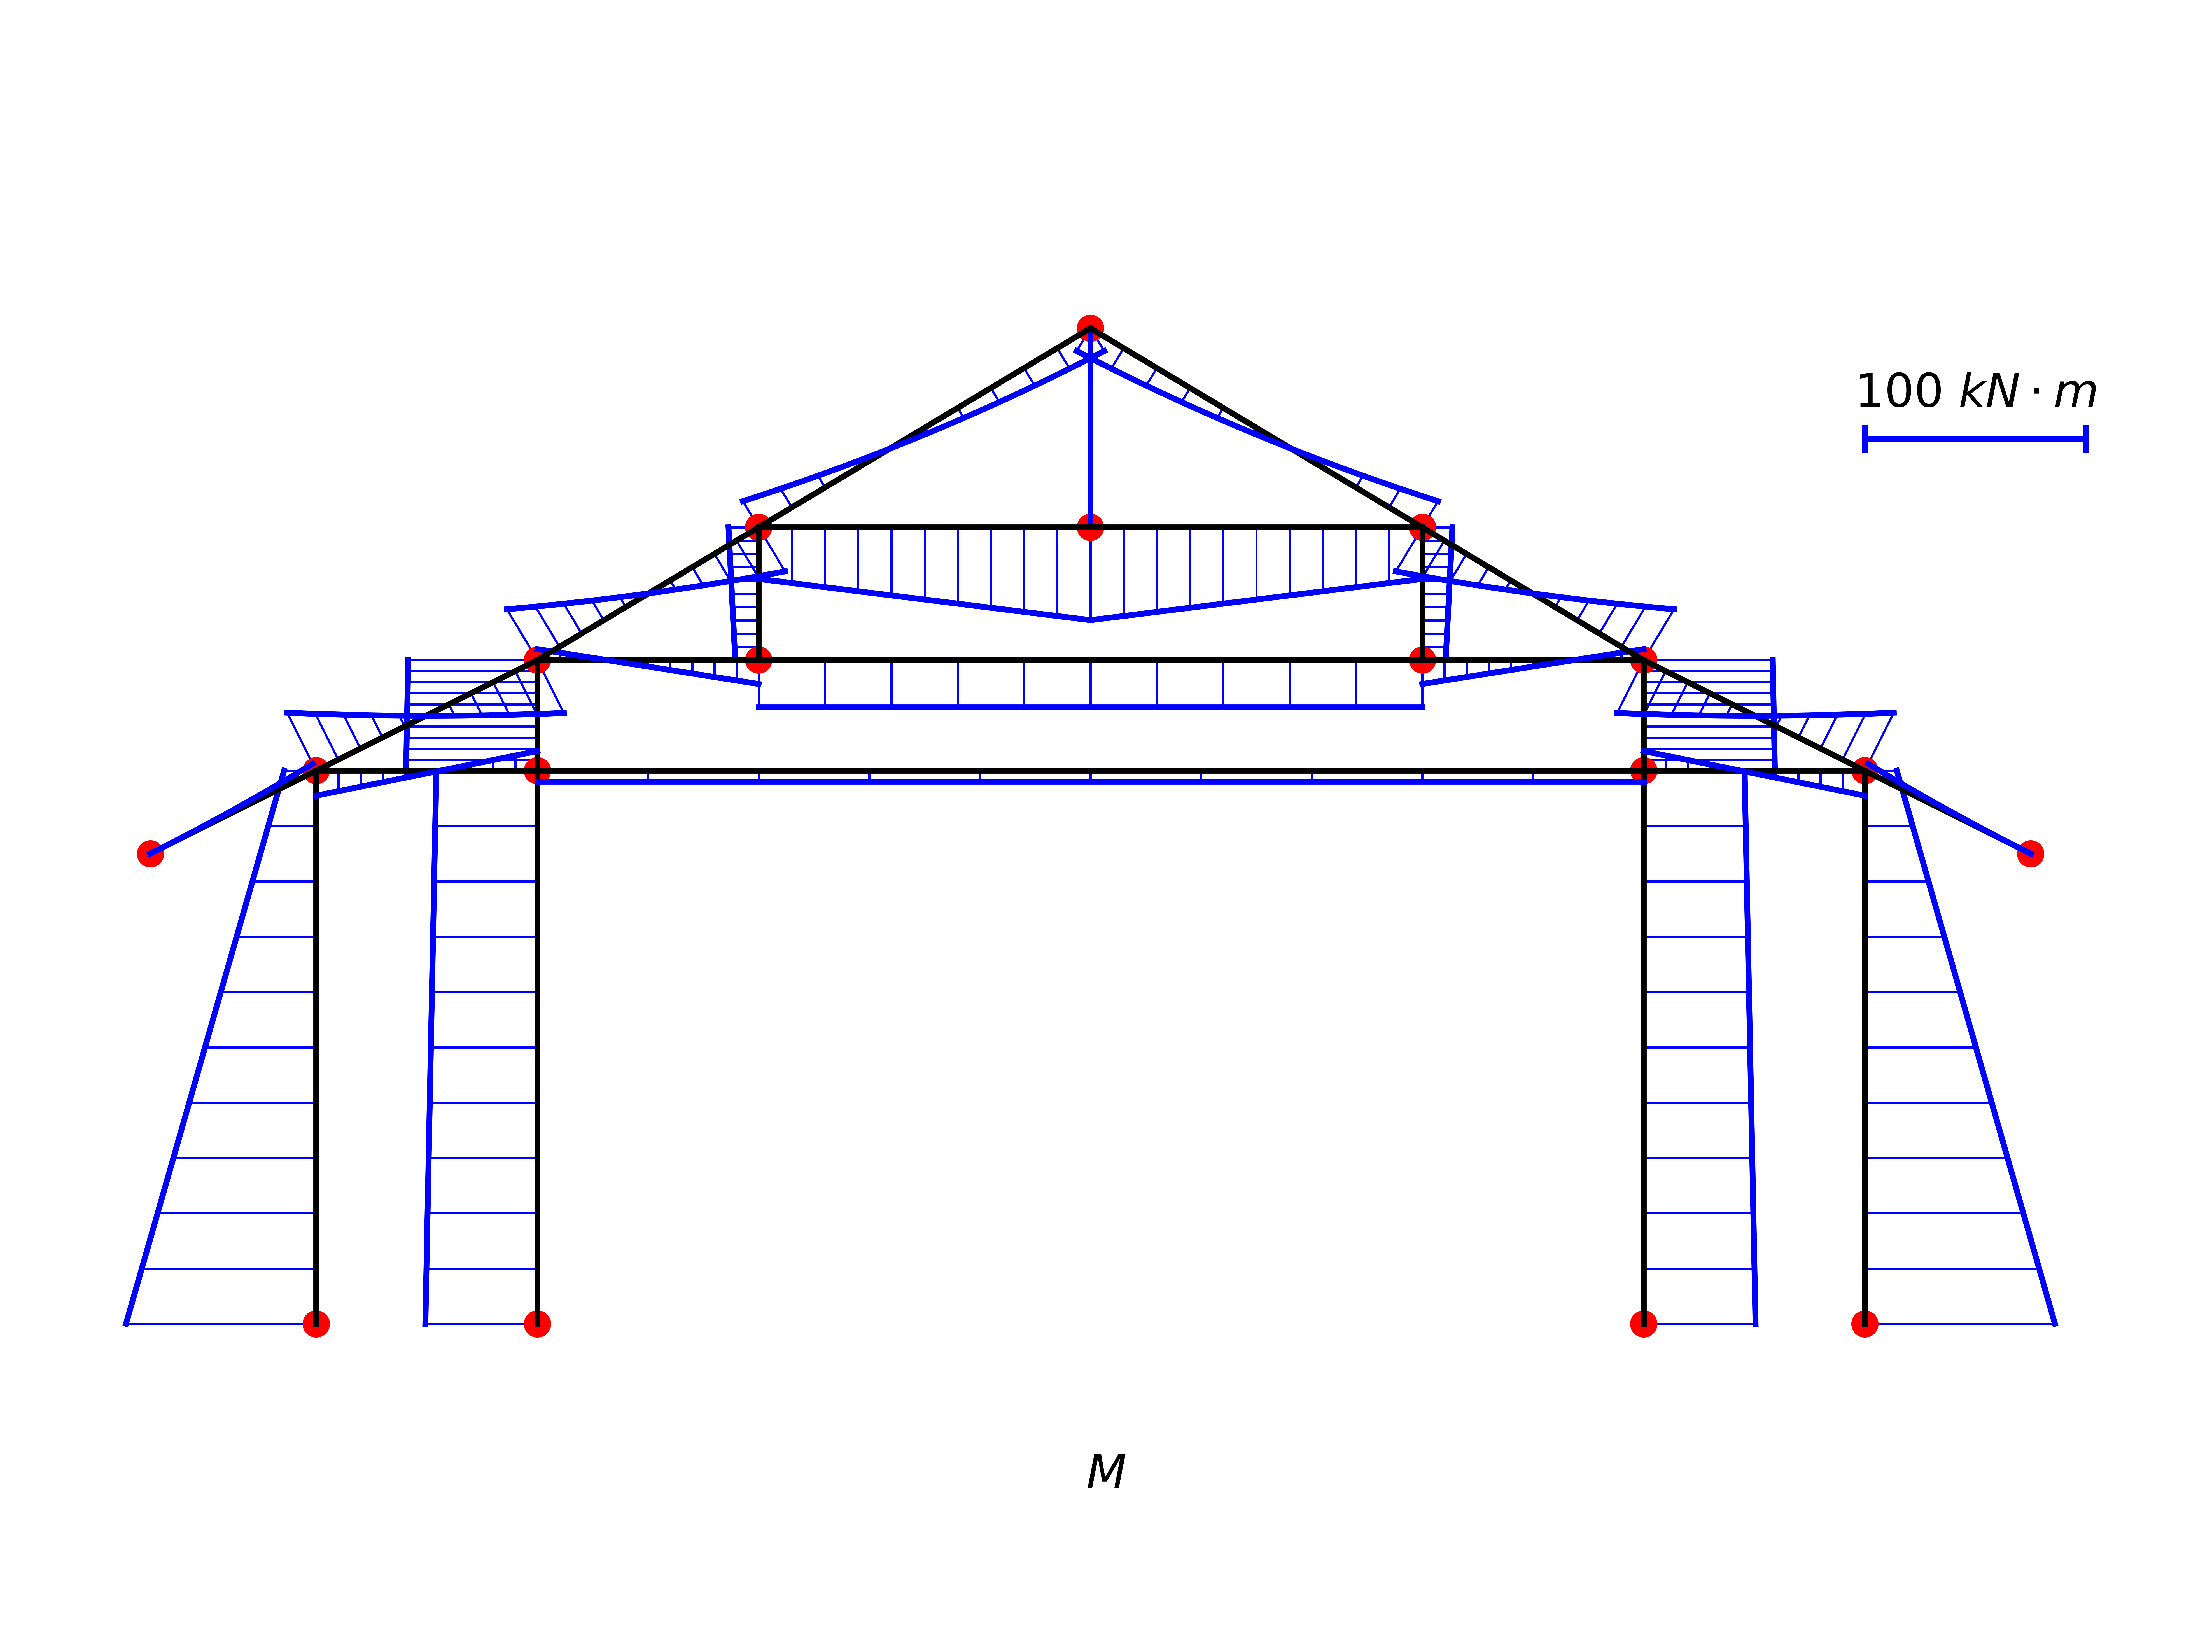

In [241]:
plt.figure(figsize=(8, 6), dpi=500)

IndexForce = 2  # 0: N, 1: Q, 2: M

for i, elem in enumerate(Elems):
    M1 = -elem.ReactionR[IndexForce]
    M2 = +elem.ReactionR[3+IndexForce]
    elem.M = np.linspace(M1,M2,DIVIDE)

for ElemLoad in ElemLoads:
    elem = ElemLoad.Element
    Index = ElemLoad.Index
    # Pos = ElemLoad.Pos
    LodVal = ElemLoad.LodVal
    L = elem.Len
    
    for k in range(DIVIDE):
        z = k*L/DIVIDE
        if (Index == 1):    # 分布力
            elem.M[k] -= 1/2 * LodVal * z * (L - z)
        elif (Index == 2):  # 集中力
            elem.M[k] += 1/2 * LodVal * (L/2 - abs(L/2 - z))
        elif (Index == 3):  # 集中力矩
            if (z < L/2):
                elem.M[k] += 1/2 * LodVal * k/DIVIDE
            if (z > L/2):
                elem.M[k] -= 1/2 * LodVal * (1 - k/DIVIDE)

for elem in Elems:
    # 获取元素的两个端点的坐标
    x1, y1 = elem.Joint1.X, elem.Joint1.Y
    x2, y2 = elem.Joint2.X, elem.Joint2.Y

    # 绘制一条从第一个端点到第二个端点的线
    plt.plot([x1, x2], [y1, y2], 'k-')

    x = np.linspace(x1,x2,DIVIDE)
    y = np.linspace(y1,y2,DIVIDE)
    
    M = elem.M
    points = []
    for k in range(DIVIDE):
        if (k%10 == 0):
            plt.arrow(x[k], y[k], M[k]/UNIT_M*elem.sinA, -M[k]/UNIT_M*elem.cosA, head_width=0, head_length=0, fc='b', ec='b',linewidth=0.5)
        points.append((x[k]+M[k]/UNIT_M*elem.sinA, y[k]-M[k]/UNIT_M*elem.cosA))
    if points:
        points_x, points_y = zip(*points)
        plt.plot(points_x, points_y, 'b-')

    
# 遍历节点列表
for j, joint in enumerate(Joints):
    GDOF = joint.GDOF
    # 获取节点的坐标
    x, y = joint.X, joint.Y
    # 绘制节点
    plt.scatter(x, y, color='r')

# 比例尺
scale_x = 7  # x坐标
scale_y = 4  # y坐标
scale_len = 1  # 线段长度
plt.plot([scale_x, scale_x + scale_len], [scale_y, scale_y], 'b-')
plt.plot([scale_x, scale_x], [scale_y - 0.05, scale_y + 0.05], 'b-')
plt.plot([scale_x + scale_len, scale_x + scale_len], [scale_y - 0.05, scale_y + 0.05], 'b-')
plt.text(scale_x + scale_len / 2, scale_y + 0.1, str(UNIT_M) + r' $kN \cdot m$', ha='center', va='bottom', fontsize=12)

plt.axis('equal')
plt.axis('off')
plt.figtext(0.5, 0.1, r"$M$", ha="center", va="bottom", fontsize=12)
plt.tight_layout()
plt.savefig('Moment'+str(NameIndex)+'.png')
plt.show()

##### 剪力$F_Q$

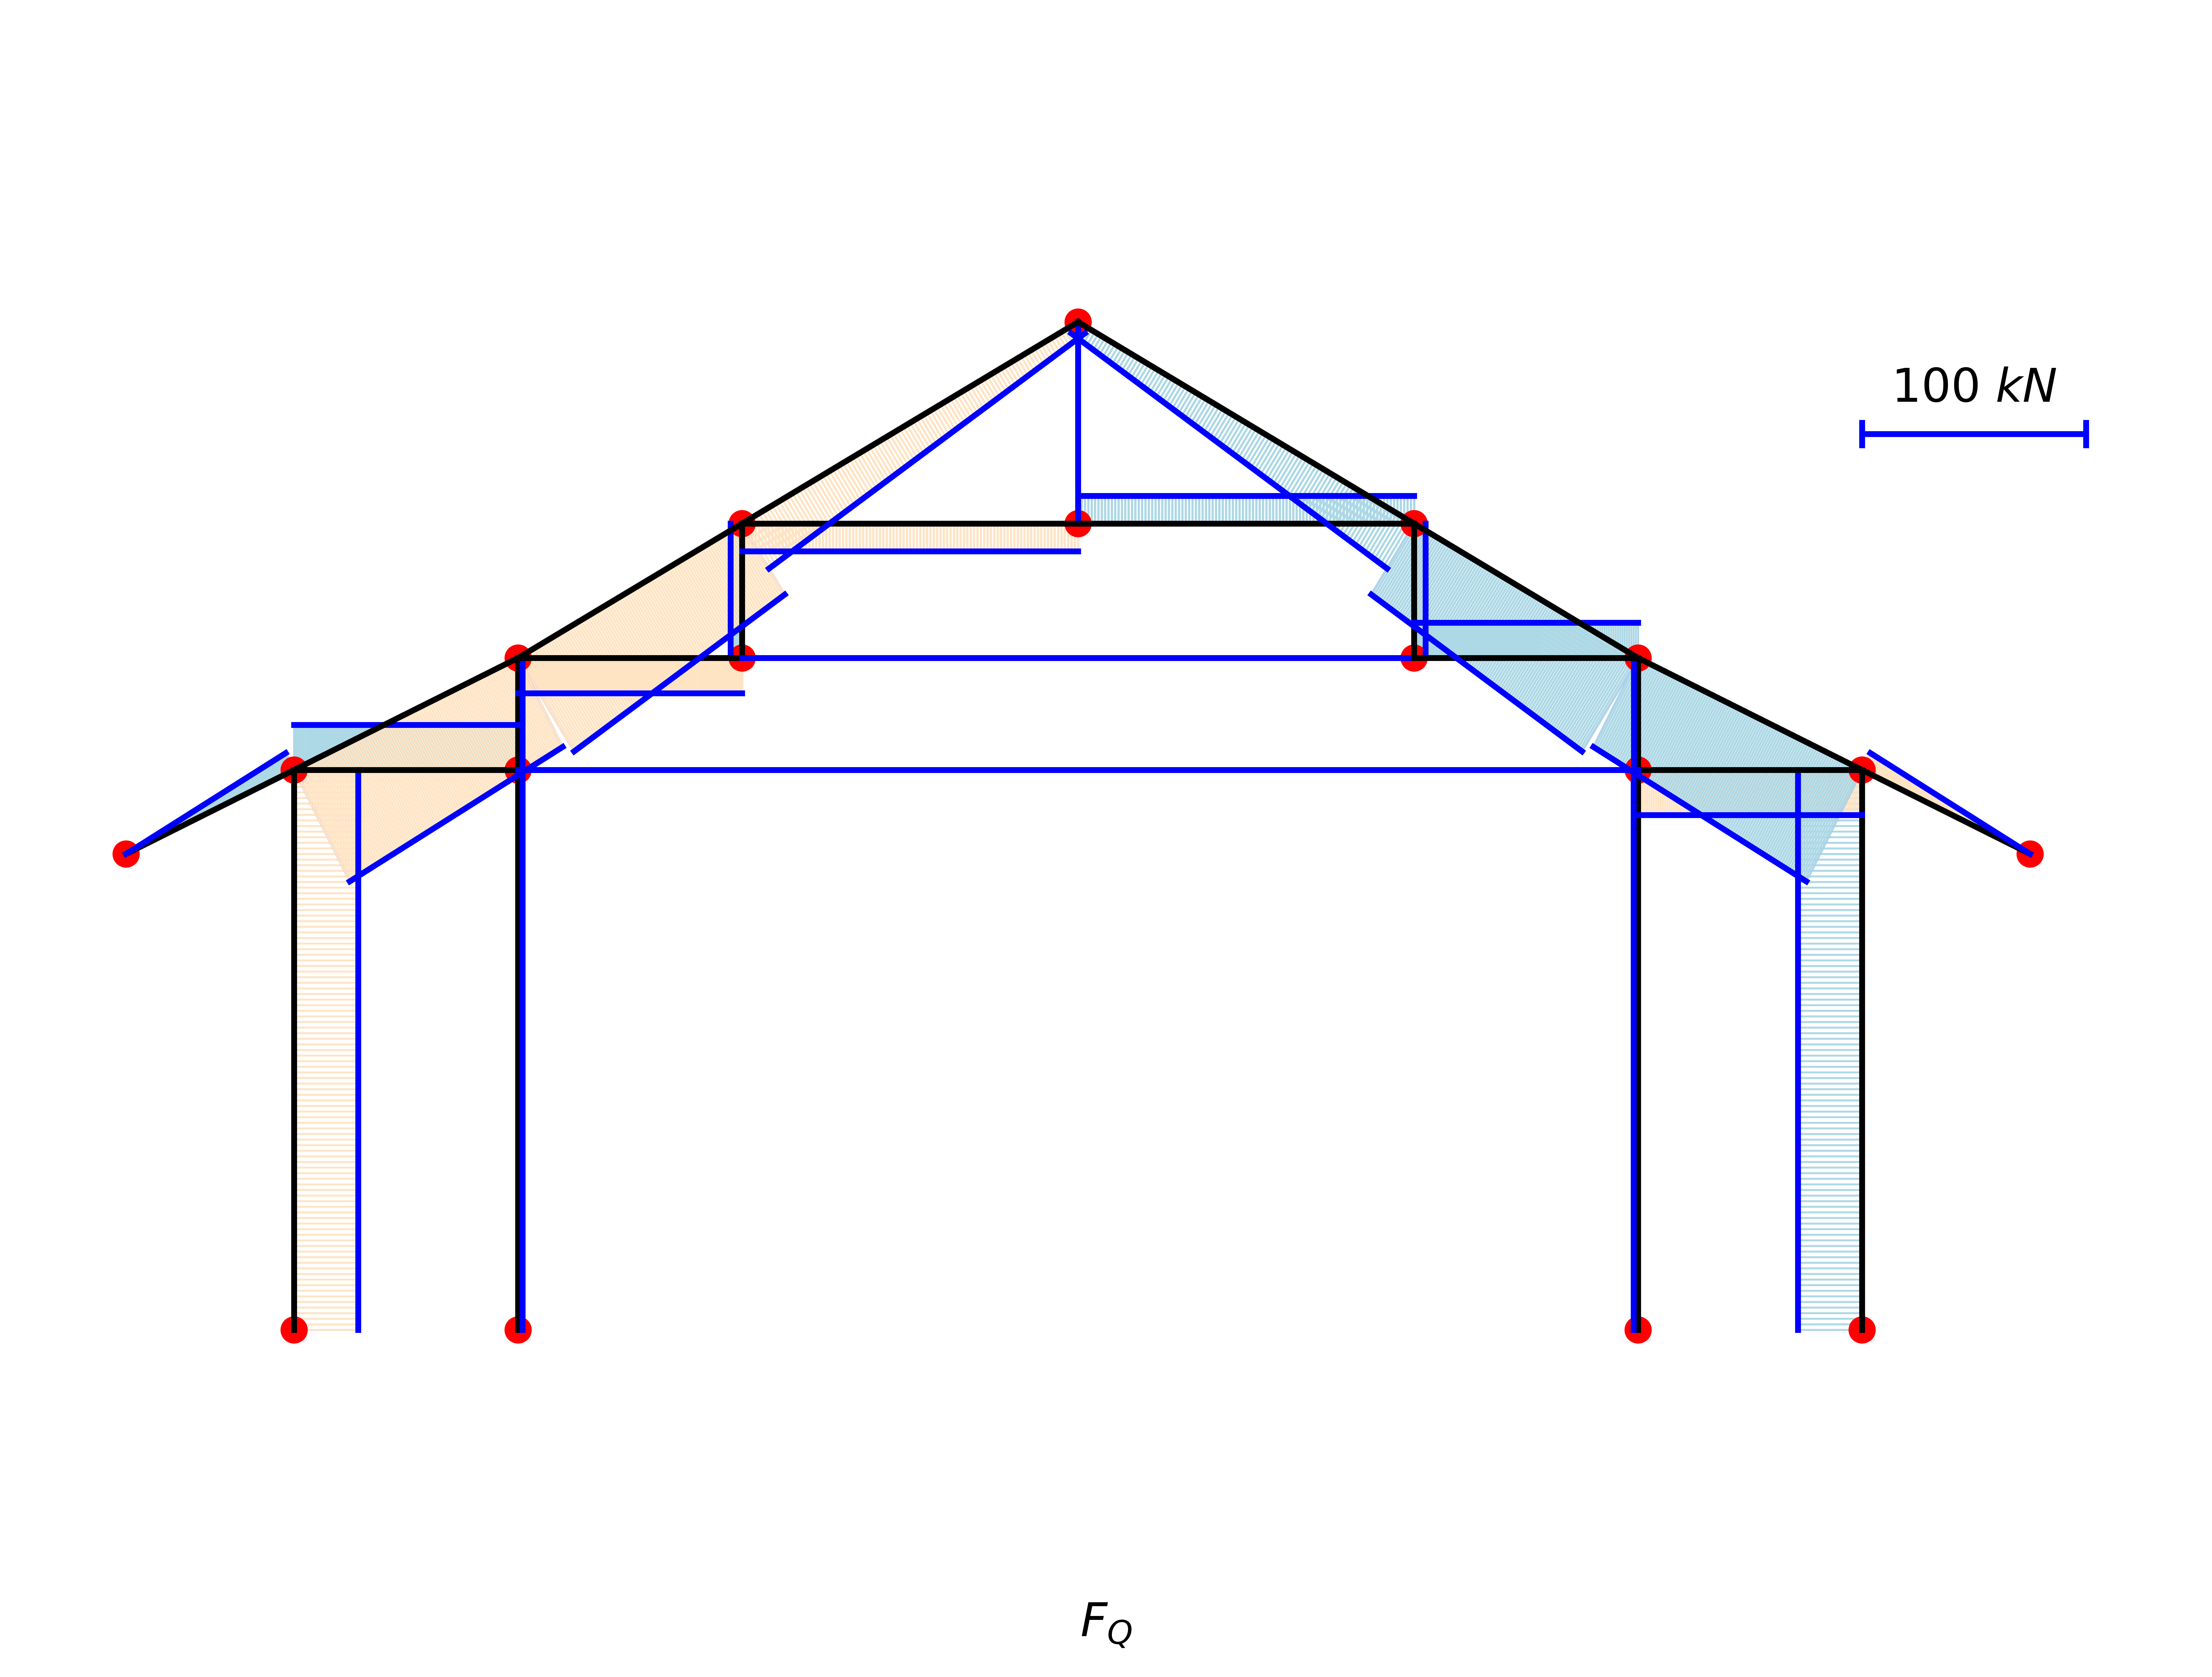

In [242]:
plt.figure(figsize=(8, 6), dpi=500)

IndexForce = 1  # 0: N, 1: Q, 2: M

for i, elem in enumerate(Elems):
    FQ1 = elem.ReactionR[IndexForce]
    FQ2 = -elem.ReactionR[3+IndexForce]
    elem.FQ = np.linspace(FQ1,FQ2,DIVIDE)

for ElemLoad in ElemLoads:
    elem = ElemLoad.Element
    Index = ElemLoad.Index
    # Pos = ElemLoad.Pos
    LodVal = ElemLoad.LodVal
    L = elem.Len
    
    for k in range(DIVIDE):
        z = k*L/DIVIDE
        if (Index == 2):  # 集中力
            if (z < L/2):
                elem.FQ[k] -= LodVal * (k/DIVIDE)
            if (z > L/2):
                elem.FQ[k] += LodVal * (1 - k/DIVIDE)

for elem in Elems:
    # 获取元素的两个端点的坐标
    x1, y1 = elem.Joint1.X, elem.Joint1.Y
    x2, y2 = elem.Joint2.X, elem.Joint2.Y

    # 绘制一条从第一个端点到第二个端点的线
    plt.plot([x1, x2], [y1, y2], 'k-')

    x = np.linspace(x1,x2,DIVIDE)
    y = np.linspace(y1,y2,DIVIDE)
    
    FQ = elem.FQ
    points = []
    for k in range(DIVIDE):
        if (k%100 == 0):
            plt.arrow(x[k], y[k], FQ[k]/UNIT_FQ*elem.sinA, -FQ[k]/UNIT_FQ*elem.cosA, head_width=0, head_length=0, fc='b', ec='b',linewidth=0.5)
        points.append((x[k]+FQ[k]/UNIT_FQ*elem.sinA, y[k]-FQ[k]/UNIT_FQ*elem.cosA))
        fill_color = 'lightblue' if FQ[k] < 0 else 'bisque'
        plt.arrow(x[k], y[k], FQ[k]/UNIT_FQ*elem.sinA, -FQ[k]/UNIT_FQ*elem.cosA, head_width=0, head_length=0, ec=fill_color,linewidth=0.5)
    if points:
        points_x, points_y = zip(*points)
        plt.plot(points_x, points_y, 'b-')
        
# 遍历节点列表
for j, joint in enumerate(Joints):
    GDOF = joint.GDOF
    # 获取节点的坐标
    x, y = joint.X, joint.Y
    # 绘制节点
    plt.scatter(x, y, color='r')

# 比例尺
scale_x = 7  # x坐标
scale_y = 4  # y坐标
scale_len = 1  # 线段长度
plt.plot([scale_x, scale_x + scale_len], [scale_y, scale_y], 'b-')
plt.plot([scale_x, scale_x], [scale_y - 0.05, scale_y + 0.05], 'b-')
plt.plot([scale_x + scale_len, scale_x + scale_len], [scale_y - 0.05, scale_y + 0.05], 'b-')
plt.text(scale_x + scale_len / 2, scale_y + 0.1, str(UNIT_FQ) + r' $kN$', ha='center', va='bottom', fontsize=12)

plt.axis('equal')
plt.axis('off')
plt.figtext(0.5, 0.01, r"$F_Q$", ha="center", va="bottom", fontsize=12)
plt.tight_layout()
plt.savefig('Shear'+str(NameIndex)+'.png')
plt.show()

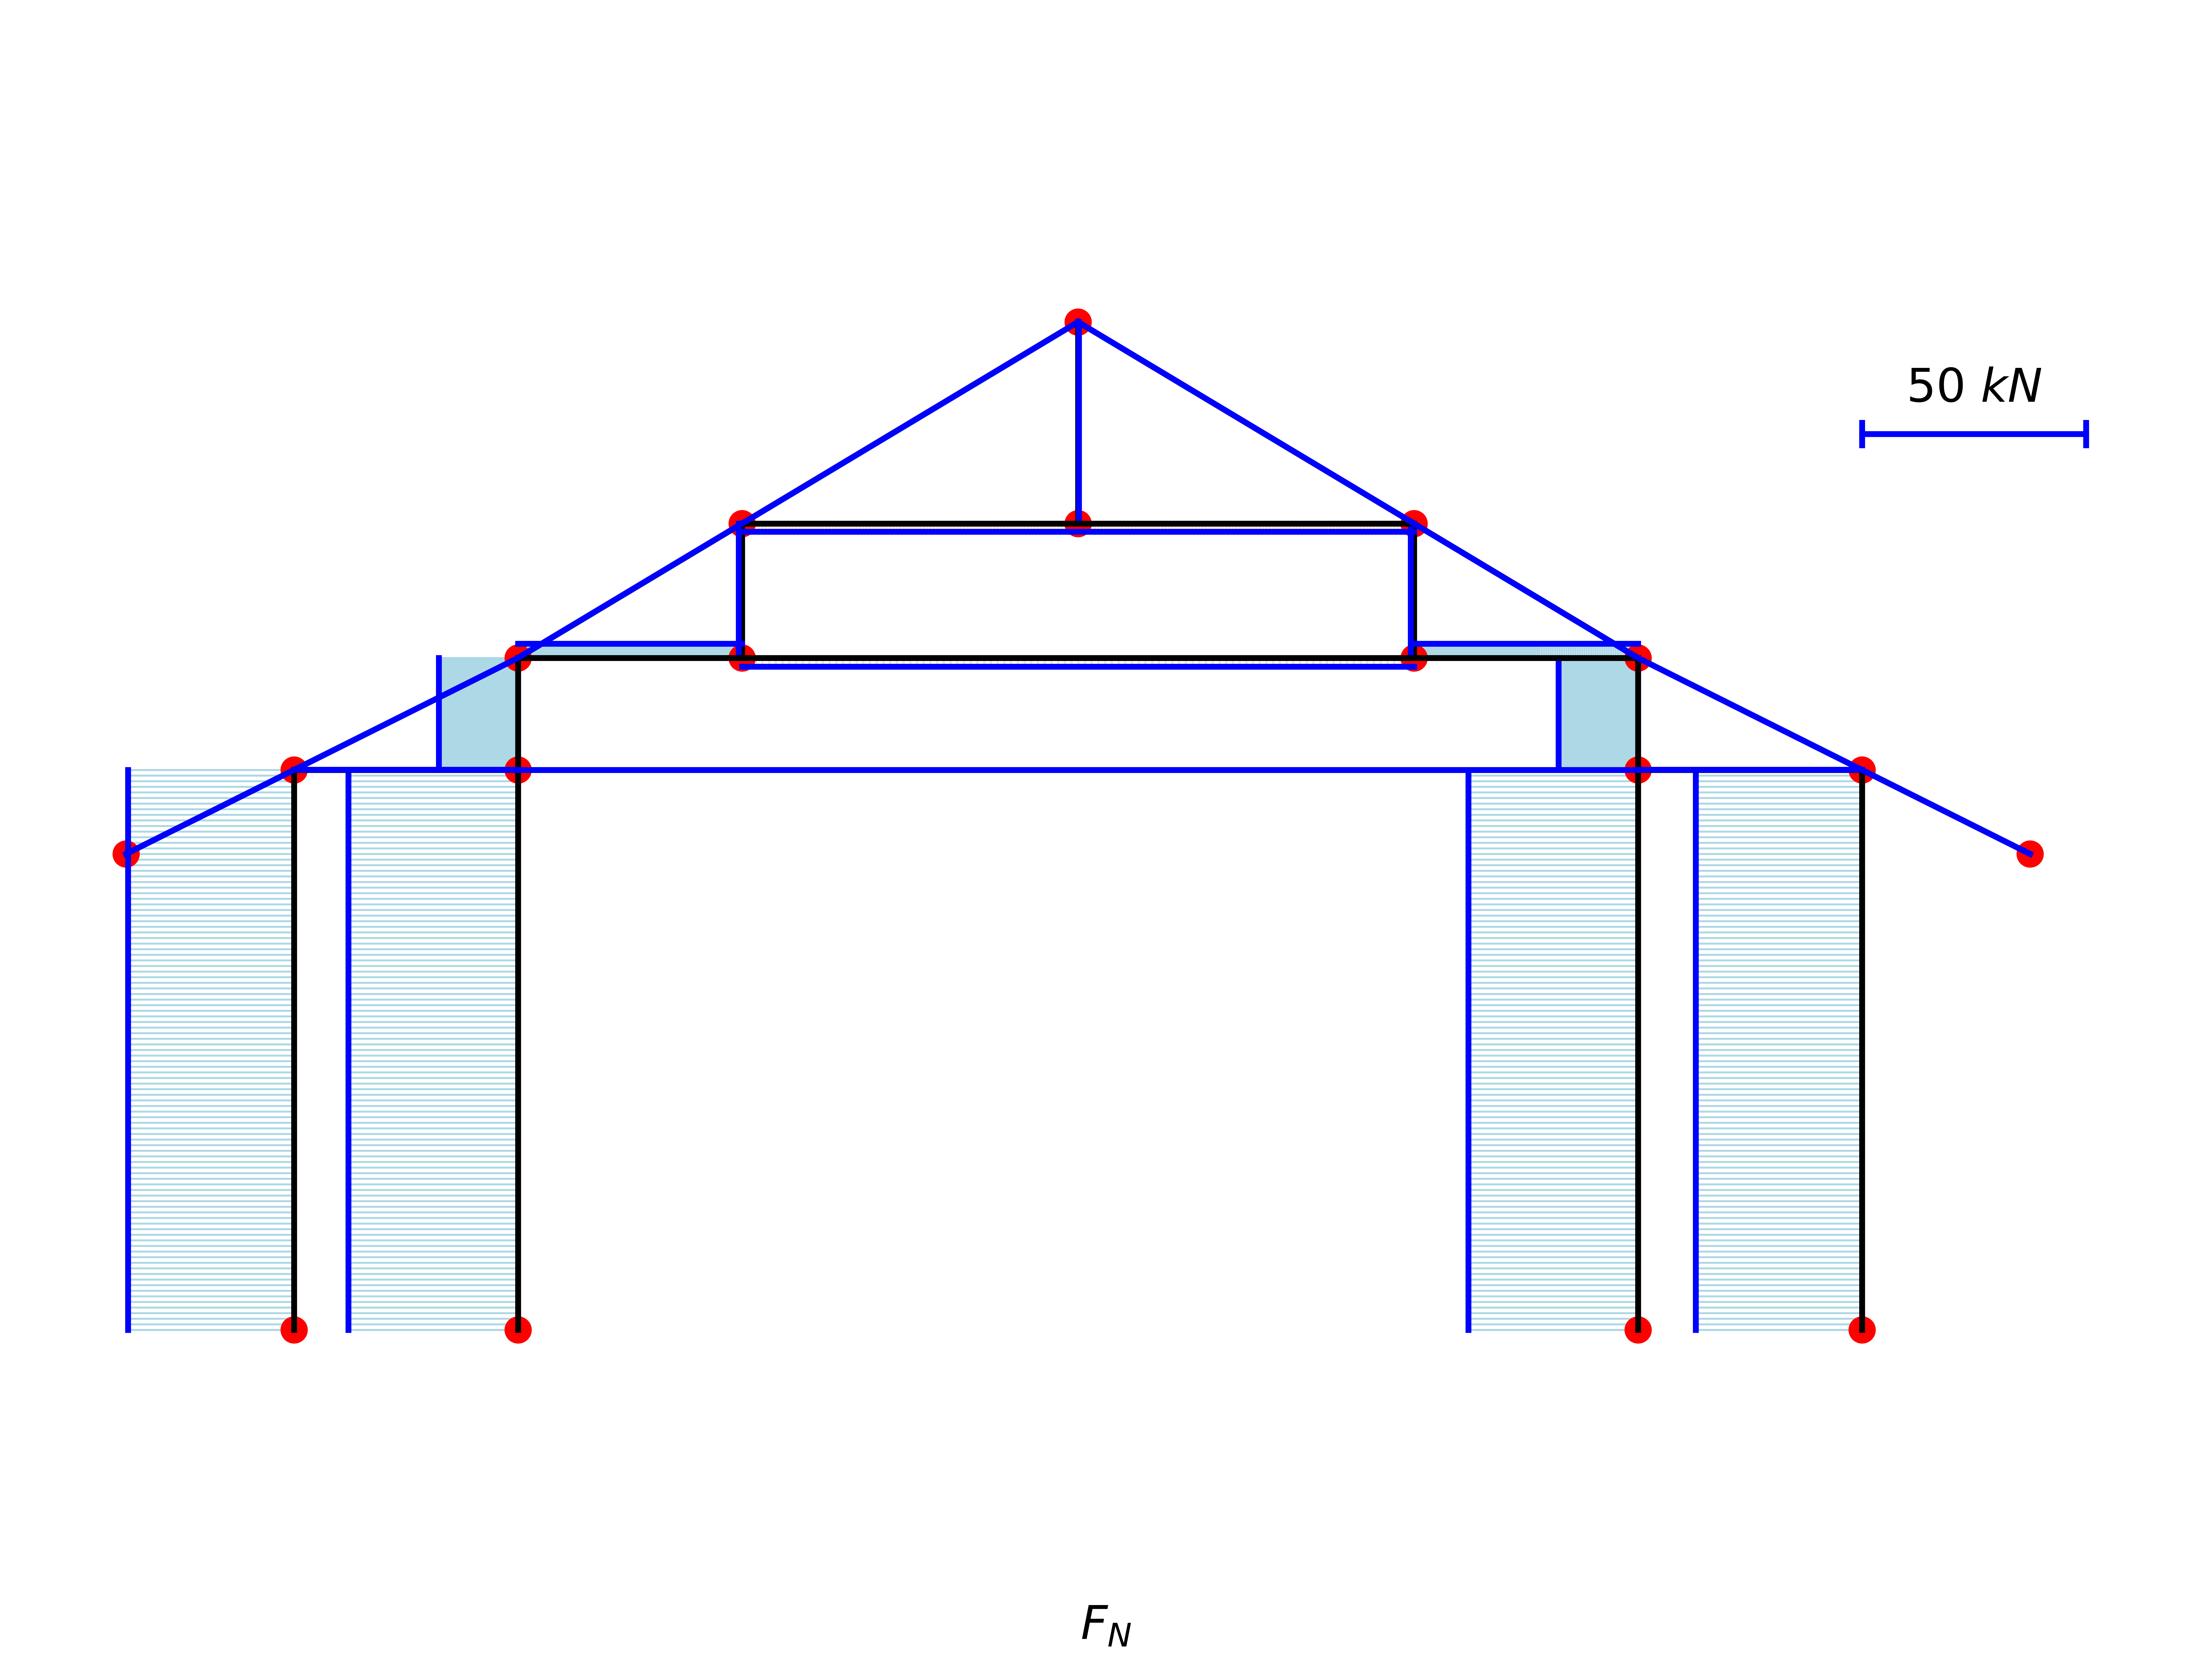

In [243]:
plt.figure(figsize=(8, 6), dpi=500)

IndexForce = 0  # 0: N, 1: Q, 2: M

for i, elem in enumerate(Elems):
    FN1 = -elem.ReactionR[IndexForce]
    FN2 = elem.ReactionR[3+IndexForce]
    elem.FN = np.linspace(FN1,FN2,DIVIDE)

    # 获取元素的两个端点的坐标
    x1, y1 = elem.Joint1.X, elem.Joint1.Y
    x2, y2 = elem.Joint2.X, elem.Joint2.Y

    # 绘制一条从第一个端点到第二个端点的线
    plt.plot([x1, x2], [y1, y2], 'k-')

    x = np.linspace(x1,x2,DIVIDE)
    y = np.linspace(y1,y2,DIVIDE)
    
    FN = elem.FN
    points = []
    for k in range(DIVIDE):
        if (k%100 == 0):
            plt.arrow(x[k], y[k], FN[k]/UNIT_FN*elem.sinA, -FN[k]/UNIT_FN*elem.cosA, head_width=0, head_length=0, fc='b', ec='b',linewidth=0.5)
        points.append((x[k]+FN[k]/UNIT_FN*elem.sinA, y[k]-FN[k]/UNIT_FN*elem.cosA))
        fill_color = 'lightblue' if FN[k] < 0 else 'bisque'
        plt.arrow(x[k], y[k], FN[k]/UNIT_FN*elem.sinA, -FN[k]/UNIT_FN*elem.cosA, head_width=0, head_length=0, ec=fill_color,linewidth=0.5)
    if points:
        points_x, points_y = zip(*points)
        plt.plot(points_x, points_y, 'b-')

    
# 遍历节点列表
for j, joint in enumerate(Joints):
    GDOF = joint.GDOF
    # 获取节点的坐标
    x, y = joint.X, joint.Y
    # 绘制节点
    plt.scatter(x, y, color='r')

# 比例尺
scale_x = 7  # x坐标
scale_y = 4  # y坐标
scale_len = 1  # 线段长度
plt.plot([scale_x, scale_x + scale_len], [scale_y, scale_y], 'b-')
plt.plot([scale_x, scale_x], [scale_y - 0.05, scale_y + 0.05], 'b-')
plt.plot([scale_x + scale_len, scale_x + scale_len], [scale_y - 0.05, scale_y + 0.05], 'b-')
plt.text(scale_x + scale_len / 2, scale_y + 0.1, str(UNIT_FN) + r' $kN$', ha='center', va='bottom', fontsize=12)

plt.axis('equal')
plt.axis('off')
plt.figtext(0.5, 0.01, r"$F_N$", ha="center", va="bottom", fontsize=12)
plt.tight_layout()
plt.savefig('Axial'+str(NameIndex)+'.png')
plt.show()